# Multimodal RAG with Command and Embed models

## Overview
Many documents contain crucial information in non-textual formats like diagrams and images, which traditional text-based RAG systems cannot leverage. Multimodal RAG addresses this by incorporating visual data into the retrieval and generation process for more comprehensive results.

This notebook demonstrates how to build a multimodal RAG pipeline using Cohere's Command and Embed models. It can answer questions about a PDF document by analyzing its pages as images.

## Contents
- Preparing PDF data for processing.
- Converting images to base64.
- Embedding document pages as images.
- Performing semantic search for retrieval.
- Generating responses from retrieved images.

In [ ]:
# %pip install -U cohere pdf2image pillow numpy

In [1]:
from pdf2image import convert_from_path
import base64
import json
from io import BytesIO
from PIL import Image

In [2]:
import cohere
import os
co = cohere.ClientV2(os.getenv("COHERE_API_KEY")) 

model = "command-a-vision"

In [3]:
pdf_path = 'data/Samsung_Home_Theatre_HW-N950_ZA_FullManual_02_ENG_180809_2.pdf'

## Prepare the data

In this section, we prepare the data by converting a PDF manual into a format suitable for multimodal RAG. The process involves:
- Loading a PDF file using pdf2image
- Converting each page to a PNG image at 200 DPI
- Encoding each image as a base64 string
- Creating a structured array where each page contains the filename and base64-encoded image
- Saving the processed data to a JSON file for later use


In [4]:
def image_to_base64(img):
    # Convert PIL image to base64
    buffered = BytesIO()
    # Save as PNG format to ensure compatibility
    img.save(buffered, format="PNG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return f"data:image/png;base64,{img_base64}"

def process_pdf(pdf_path):
    input_data = []
    filename = os.path.basename(pdf_path)
    
    print(f"Processing {filename}...")

    # Convert PDF pages to images
    pages = convert_from_path(pdf_path, dpi=200)

    for page in pages:
        base64_image = image_to_base64(page)

        page_entry = {
            "content": [
                {"type": "text", "text": f"{filename}"},
                {"type": "image_url", "image_url": {"url": base64_image}}
            ]
        }

        input_data.append(page_entry)

    return input_data

# Run it
input_array = process_pdf(pdf_path)
    
len(input_array)

Processing Samsung_Home_Theatre_HW-N950_ZA_FullManual_02_ENG_180809_2.pdf...


47

## Embed the documents

In [5]:
# Generate embeddings for each PDF page. This may take a few minutes.
doc_emb = []
for i in range(0, len(input_array), 50):
    batch = input_array[i : i + 80]
    res = co.embed(
        model="embed-v4.0",
        input_type="search_document",
        embedding_types=["float"],
        inputs=batch,
    ).embeddings.float
    doc_emb.extend(res)

## Perform semantic search

In [6]:
# Add the user query
query = "How to use the voice command"

# Embed the query
query_emb = co.embed(
    model="embed-v4.0",
    input_type="search_query",
    texts=[query],
    embedding_types=["float"],
).embeddings.float

Rank: 1
Score: 0.41369873130741613
Document text: Samsung_Home_Theatre_HW-N950_ZA_FullManual_02_ENG_180809_2.pdf




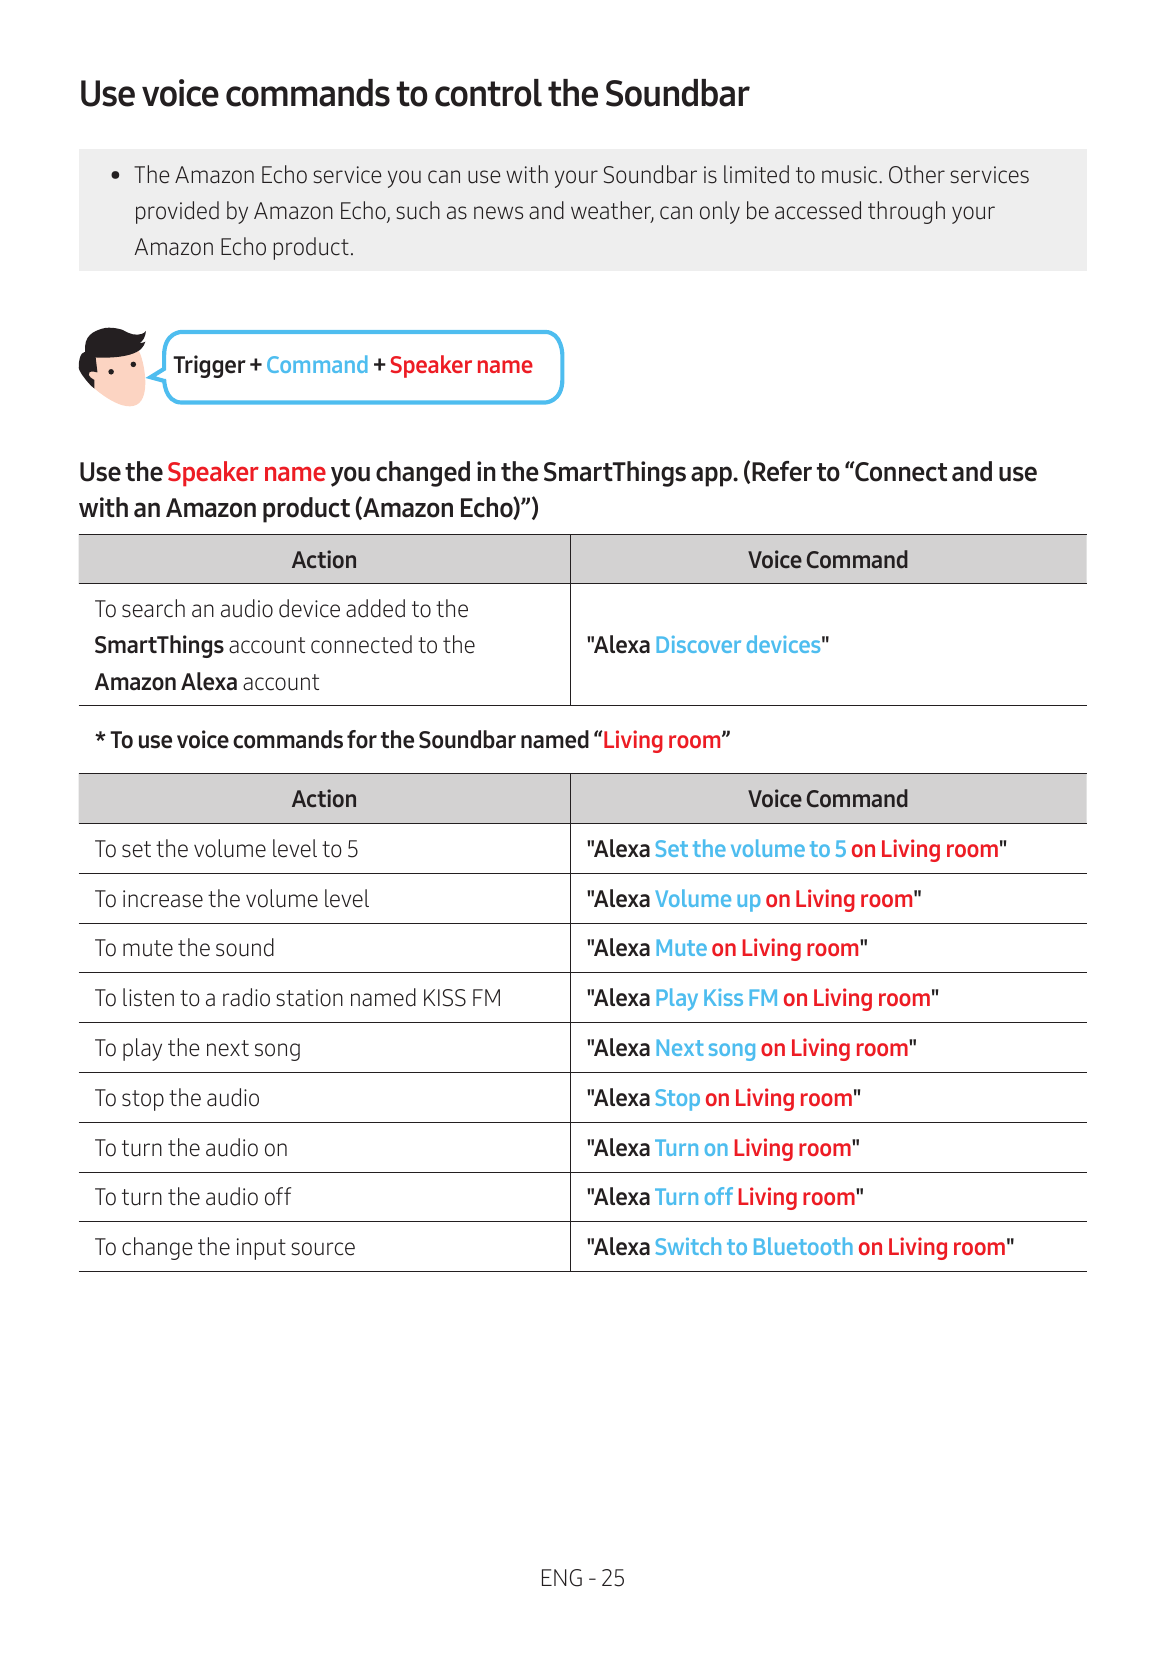

In [8]:
import numpy as np
from IPython.display import Image as IPImage, display

# Compute dot product similarity and display results
def return_results(query_emb, doc_emb, input_array):
    top_n = 1 # customize your top N results
    scores = np.dot(query_emb, np.transpose(doc_emb))[0]
    top_idxs = np.argsort(-scores)[:top_n]

    for rank, idx in enumerate(top_idxs):
        print(f"Rank: {rank+1}")
        print(f"Score: {scores[idx]}")
        print(f"Document text: {input_array[idx]['content'][0]['text']}\n")
        
        # Display image for each result
        image_url = input_array[idx]['content'][1]['image_url']['url']
        display(IPImage(url=image_url))
            
    return top_idxs


top_idxs = return_results(query_emb, doc_emb, input_array)

## RAG with retrieval and response generation

In [ ]:
# Get top ranked results
top_image_urls = []
for idx in top_idxs:
    image_url = input_array[idx]['content'][1]['image_url']['url']
    top_image_urls.append({"type": "image_url", "image_url": {"url": image_url}})

# Generate response using command-a-vision
response = co.chat(
    model=model,
    messages=[
        {
            "role": "user", 
            "content": [
                {"type": "text", "text": query}
            ] + top_image_urls
        }
    ]
)

print("Response:")
print(response.message.content[0].text)

# Display all returned images
# print("Top ranked images:")
# for i, idx in enumerate(top_idxs):
#     image_url = input_array[idx]['content'][1]['image_url']['url']
#     print(f"Rank {i+1}:")
#     display(IPImage(url=image_url))

Response:
To use voice commands to control the Soundbar, follow these steps:

1. **Understand the Limitations**: The Amazon Echo service with your Soundbar is limited to music. Other services like news and weather can only be accessed through your Amazon Echo product.

2. **Use the Correct Speaker Name**: Use the Speaker name you changed in the SmartThings app. Refer to "Connect and use with an Amazon product (Amazon Echo)" for this name.

3. **Discover Devices**: To search for an audio device added to the SmartThings account connected to the Amazon Alexa account, use the voice command:  
   *"Alexa, Discover devices."*

4. **Control the Soundbar**: For the Soundbar named "Living room," use the following voice commands:

   - **Set Volume to 5**:  
     *"Alexa, Set the volume to 5 on Living room."*
   - **Increase Volume**:  
     *"Alexa, Volume up on Living room."*
   - **Mute Sound**:  
     *"Alexa, Mute on Living room."*
   - **Play Radio Station (KISS FM)**:  
     *"Alexa, Play

## Conclusion
This notebook covered the process of building a multimodal RAG system. It showed how to process a PDF into images, embed them for semantic search, retrieve relevant images for a query, and generate a final answer using a vision-capable model.